In [3]:
import re
import nltk 
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from nltk.tokenize import TweetTokenizer
from collections import defaultdict 

In [6]:
dataset_path = "sentiment_analysis.csv"
df = pd.read_csv(
    dataset_path,
    index_col = 'id'
)

In [7]:
df.head()

,label,tweet
id,,
1,0,#fingerprint #Pregnancy Test https://goo.gl/h1...
2,0,Finally a transparant silicon case ^^ Thanks t...
3,0,We love this! Would you go? #talk #makememorie...
4,0,I'm wired I know I'm George I was made that wa...
5,1,What amazing service! Apple won't even talk to...


In [9]:
def text_normalize(text):
    # Retweet old acronym "RT" removal
    text = re.sub(r'^RT [\s]+', '', text)

    # Hyperlinks removal
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)

    # Hashtags removal
    text = re.sub(r'#', '', text)

    # Punctuation removal
    text = re.sub(r' [^\w\s]', '', text)

    # Tokenization
    tokenizer = TweetTokenizer(
        preserve_case=False,
        strip_handles=True,
        reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)

    return text_tokens

In [10]:
def get_freqs(df):
    freqs = defaultdict(lambda: 0)
    for idx, row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        
        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token, label)
            freqs[pair] += 1
            
    return freqs

In [11]:
def get_feature(text, freqs):
    tokens = text_normalize(text)
    
    X = np.zeros(3)
    X[0] = 1
    
    for token in tokens:
        X[1] += freqs[(token, 1)]
        X[2] += freqs[(token, 0)]
        
    return X 

In [12]:
X = []
y = []

freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row['tweet']
    label = row['label']
    
    X_i = get_feature(tweet, freqs)
    
    X.append(X_i)
    y.append(label)
    
X = np.array(X)
y = np.array(y)
    

In [17]:
val_size = 0.2
test_size = 0.125
random_state = 2
is_shuffle = True 

X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=val_size, 
    random_state=random_state, 
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, 
    test_size=test_size, 
    random_state=random_state, 
    shuffle=is_shuffle
)

In [18]:
normalizer = StandardScaler()
X_train[:, 1:] = normalizer.fit_transform(X_train[:, 1:])
X_val[:, 1:] = normalizer.transform(X_val[:, 1:])
X_test[:, 1:] = normalizer.transform(X_test[:, 1:])

In [19]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def predict(X, theta):
    dot_product = np.dot(X, theta)
    y_hat = sigmoid(dot_product)
    return y_hat

def compute_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7)
    return (-y * np.log(y_hat) - (1 - y) * np.log(1 - y_hat)).mean()

def compute_gradient(X, y, y_hat):
    return np.dot(X.T, (y_hat - y)) / y.size

def update_theta(theta, gradient, learning_rate):
    return theta - learning_rate * gradient

def compute_accuracy(X, y, theta):
    y_hat = predict(X, theta).round()
    acc = (y_hat == y).mean()
    
    return acc 

In [20]:
lr = 0.01
epochs = 200
batch_size = 128

np.random.seed(random_state)
theta = np.random.uniform(
    size=X_train.shape[1]
)

In [21]:
train_accs = []
train_losses = []
val_accs = []
val_losses = []

for epoch in range(epochs):
    train_batch_losses = []
    train_batch_accs = []
    val_batch_losses = []
    val_batch_accs = []
    
    for i in range(0, X_train.shape[0], batch_size):
        X_i = X_train[i:i + batch_size]
        y_i = y_train[i:i + batch_size]
        
        y_hat = predict(X_i, theta)
        
        loss = compute_loss(y_hat, y_i)
        
        gradient = compute_gradient(X_i, y_i, y_hat)
        
        theta = update_theta(theta, gradient, lr)
        
        train_batch_losses.append(loss)
        
        acc = compute_accuracy(X_i, y_i, theta)
        train_batch_accs.append(acc)
        
        y_hat_val = predict(X_val, theta)
        val_loss = compute_loss(y_hat_val, y_val)
        val_batch_losses.append(val_loss)
        
        val_acc = compute_accuracy(X_val, y_val, theta)
        val_batch_accs.append(val_acc)
        
    train_batch_loss = sum(train_batch_losses) / len(train_batch_losses)
    train_batch_acc = sum(train_batch_accs) / len(train_batch_accs)
    val_batch_loss = sum(val_batch_losses) / len(val_batch_losses)
    val_batch_acc = sum(val_batch_accs) / len(val_batch_accs)
    
    train_losses.append(train_batch_loss)
    train_accs.append(train_batch_acc)
    val_accs.append(val_batch_acc)
    val_losses.append(val_batch_loss)
    
    print(f"\nEPOCH {epoch + 1}:\tTrainning loss: {train_batch_loss:.3f}\tValidation_loss: {val_batch_loss:.3f}")


EPOCH 1:	Trainning loss: 0.774	Validation_loss: 0.778

EPOCH 2:	Trainning loss: 0.727	Validation_loss: 0.731

EPOCH 3:	Trainning loss: 0.688	Validation_loss: 0.692

EPOCH 4:	Trainning loss: 0.656	Validation_loss: 0.659

EPOCH 5:	Trainning loss: 0.630	Validation_loss: 0.632

EPOCH 6:	Trainning loss: 0.607	Validation_loss: 0.610

EPOCH 7:	Trainning loss: 0.588	Validation_loss: 0.591

EPOCH 8:	Trainning loss: 0.572	Validation_loss: 0.575

EPOCH 9:	Trainning loss: 0.559	Validation_loss: 0.561

EPOCH 10:	Trainning loss: 0.547	Validation_loss: 0.549

EPOCH 11:	Trainning loss: 0.537	Validation_loss: 0.538

EPOCH 12:	Trainning loss: 0.528	Validation_loss: 0.529

EPOCH 13:	Trainning loss: 0.520	Validation_loss: 0.521

EPOCH 14:	Trainning loss: 0.513	Validation_loss: 0.514

EPOCH 15:	Trainning loss: 0.507	Validation_loss: 0.508

EPOCH 16:	Trainning loss: 0.501	Validation_loss: 0.502

EPOCH 17:	Trainning loss: 0.496	Validation_loss: 0.497

EPOCH 18:	Trainning loss: 0.492	Validation_loss: 0.492



[Text(0.5, 0, 'Epochs'), Text(0, 0.5, 'Accuracy')]

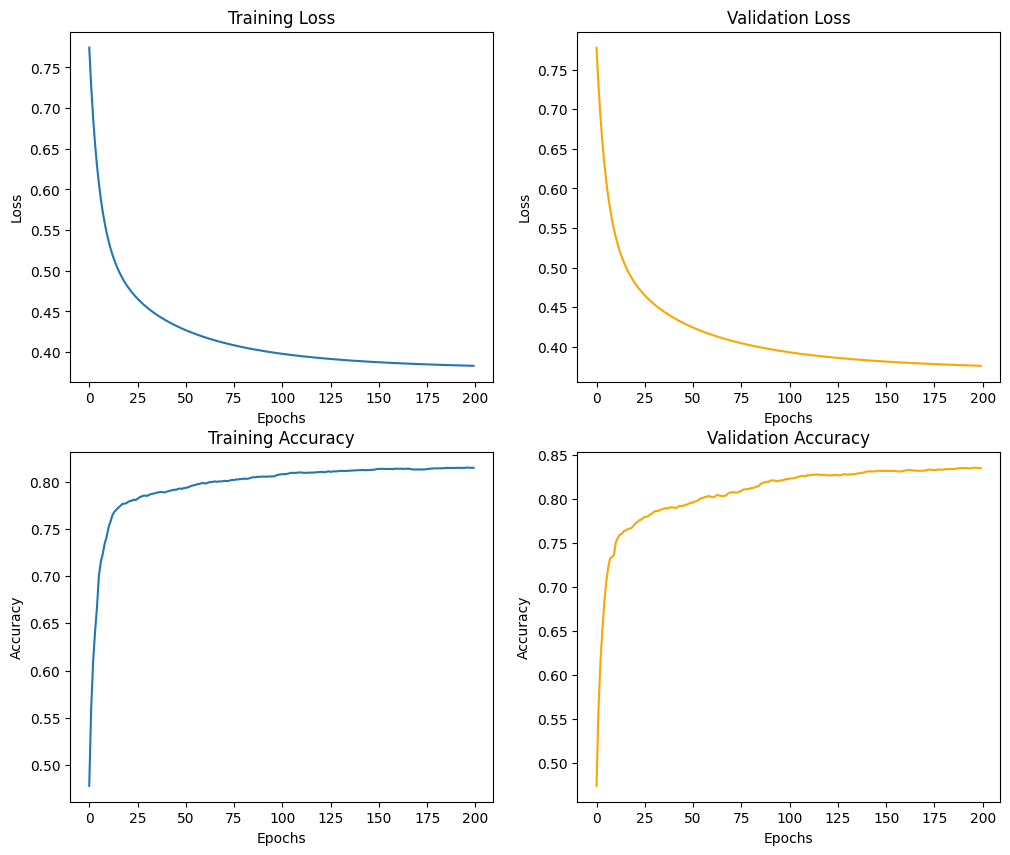

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses)
ax[0, 0].set_title("Training Loss")
ax[0, 0].set(xlabel="Epochs", ylabel="Loss")

ax[0, 1].plot(val_losses, "orange")
ax[0, 1].set_title("Validation Loss")
ax[0, 1].set(xlabel="Epochs", ylabel="Loss")

ax[1, 0].plot(train_accs)
ax[1, 0].set_title("Training Accuracy")
ax[1, 0].set(xlabel="Epochs", ylabel="Accuracy")

ax[1, 1].plot(val_accs, "orange")
ax[1, 1].set_title("Validation Accuracy")
ax[1, 1].set(xlabel="Epochs", ylabel="Accuracy")

In [23]:
val_set_acc = compute_accuracy(X_val, y_val, theta)
test_set_acc = compute_accuracy(X_test, y_test, theta)
print("Evaluation on validation and test set:")
print(f"Validation set accuracy: {val_set_acc:.3f}")
print(f"Test set accuracy: {test_set_acc:.3f}")

Evaluation on validation and test set:
Validation set accuracy: 0.836
Test set accuracy: 0.835
